In [1]:
import os
import random
import time

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sympy.physics.units import length
from torchvision import transforms, models
from torchvision.transforms.functional import to_pil_image

from collections import defaultdict
from optuna import trial

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
import optuna
import wandb
# Project utilities
import utils
import importlib
import train
importlib.reload(train)
importlib.reload(utils)
from train import train_model_with_hyperparams

VGG19 = 'VGG19'
ALEXNET = 'AlexNet'

# Set seed
SEED = utils.SEED
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check if you're working locally or not
if not (os.path.exists(utils.CSV_PATH) and os.path.exists(utils.OPTIMIZED_DIR)):
    print(f"[!] You are NOT on the project's directory [!]\n"
          f"Please run the following command (in either CMD or anaconda prompt): \n"
          f"jupyter notebook --notebook-dir PROJECT_DIR\n"
          r"Where PROJECT_DIR is the project's directory in your computer e.g: C:\Users\amitr5\PycharmProjects\deep_van_gogh")

### Loading our data
We will load the optimized datasets from our custom dataset object


In [3]:
class NumPyDataset(Dataset):
    def __init__(self, file_path):
        data = np.load(file_path)
        self.images = data["images"]
        self.labels = data["labels"]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = torch.tensor(self.images[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

dataset = NumPyDataset(os.path.join(utils.OPTIMIZED_DIR, 'dataset.npz'))

You can find the optimized dataset files <a href="https://drive.google.com/drive/folders/16vIyBwzvGgC-bJObJZT-RgZJmh3fj4Vt?usp=drive_link">HERE inside the data folder</a>. Note that you must have the data folder in the project directory<br/>
Loading the train and test datasets:

In [4]:
classes = pd.read_csv(utils.CSV_PATH)
train_rows = classes[classes['subset'] == 'train']
train_indices, val_indices = train_test_split(train_rows.index.to_list(), test_size=0.2, random_state=utils.SEED, stratify=train_rows['is_van_gogh'])
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, classes[classes['subset'] == 'test'].index.tolist()).dataset

In [5]:
def get_opt_dataset(dataset_name, train_idx=None, val_idx=None):
    data = NumPyDataset(os.path.join(utils.OPTIMIZED_DIR, f'{dataset_name}.npz'))
    if train_idx and val_idx:
        return Subset(data, train_idx), Subset(data, val_idx)

    return Subset(data, train_idx if train_idx else val_idx).dataset

flip_dataset = get_opt_dataset('flip', train_indices)
dropout_dataset = get_opt_dataset('dropout',train_indices)
affine_dataset = get_opt_dataset('affine', train_indices)
blur_dataset = get_opt_dataset('blur', train_indices)
augmented_train_dataset = ConcatDataset([train_dataset, flip_dataset, dropout_dataset, affine_dataset, blur_dataset])

### Data Augmentation

For a detailed explanation about our data augmentation, please check augmentation_demo.ipynb

# Fine tuning VGG19

In [6]:
class FinedTunedModel(nn.Module):
    def __init__(self, base_model, architecture:str):
        super(FinedTunedModel, self).__init__()
        self._architecture = architecture  # Save the base model architecture
        base_children_list = list(base_model.children())
        self.features_extractor = nn.Sequential(*base_children_list[:-1]).to(device)
        for param in self.features_extractor.parameters():
            param.requires_grad = False

        # Modify the classifier to fit to our problem (2 classes)
        self.classifier = nn.Sequential(*base_children_list[-1])
        self.classifier[-1] = nn.Linear(4096, 2).to(device)  # Replaces the final layer of the base model's classifier with a new fully connected layer

    def forward(self, x):
        base_model_output = self.features_extractor(x)
        return self.classifier(torch.flatten(base_model_output, start_dim=1))
    @property
    def architecture(self):
        return self._architecture

In [7]:
# Load pre-trained models
vgg19 = models.vgg19(weights=models.VGG19_Weights.DEFAULT).to(device)
alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT).to(device)

In [8]:
def cross_validation(learning_rate,
                     weight_decay,
                     num_layers_finetune,
                     criterion,
                     epochs,
                     patience,
                     device,
                     architecture,
                     batch_size=128, trial=None, project='project'):
    k_folds = 4
    kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    labels = []
    for dataset in augmented_train_dataset.datasets:
        labels.extend([label for _, label in dataset])

    labels = np.array(labels)

    # Track performance for each model
    base_model = vgg19 if architecture == VGG19 else alexnet
    best_values = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(np.zeros(len(labels)), labels)):
        wandb.init(project = project,
                       config={ "learning_rate": learning_rate,
                                "weight_decay": weight_decay,
                                "patience": patience,
                                "batch_size": batch_size,
                                "epochs": epochs,
                                "num_layers_finetune": num_layers_finetune,
                                "fold": fold + 1,
                                "trial": trial.number + 1,
                                "architecture": architecture,
                                "dataset": "Post_Impressionism",
                                }, name=f'{architecture}_trial_{trial.number + 1 if trial else -1}_fold_{fold+1}')

        train_subset = Subset(augmented_train_dataset, train_idx)
        val_subset = Subset(augmented_train_dataset, val_idx)

        # Create data loaders
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        model = FinedTunedModel(base_model, architecture).to(device)
        if num_layers_finetune:
            for param in model.features_extractor[-num_layers_finetune:].parameters():
                param.requires_grad = True

        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # Train the model
        best_metrics = train_model_with_hyperparams(model,
                                                train_loader,
                                                val_loader,
                                                optimizer,
                                                criterion,
                                                epochs=epochs,
                                                patience=patience,
                                                device=device,
                                                trial=trial,
                                                architecture=architecture, fold=fold + 1)
        best_values.append(best_metrics)
        # Finish the Weights & Biases run
        wandb.finish()
    mean_dict = utils.mean_dict(best_values)
    return mean_dict


In [9]:
def objective(trial, architecture, config: dict) -> float:
    """
    Generic Optuna objective function.
    :param trial: Optuna trial object.
    :param model: The neural network model to train
    :param config: A dictionary with configurable values such as learning rate ranges, batch size ranges, etc.
    :return:  best_val_loss: The best validation loss achieved during training.
    """
    # Hyperparameter suggestions based on config
    learning_rate = trial.suggest_float("learning_rate",
                                        config.get("lr_min", 1e-5),
                                        config.get("lr_max", 1e-3),
                                        log=True)
    weight_decay = trial.suggest_float("weight_decay",
                                       config.get("wd_min", 1e-6),
                                       config.get("wd_max", 1e-4),
                                       log=True)
    # Including the option not to perform fine-tuning, or only a small num of layers within the feature extractor.
    num_layers_finetune = trial.suggest_int("num_layers_finetune", 0, 3)
    batch_min = config.get("batch_size_min", 32)
    batch_max =config.get("batch_size_max", 256)
    batch_size = trial.suggest_categorical("batch_size",
                                   [2**i for i in range(int(np.log2(batch_min)), int(np.log2(batch_max))+1)]
                                   )

    epochs = trial.suggest_int("epochs", config.get("epochs_min", 10), config.get("epochs_max",30))
    # patience = trial.suggest_int("patience", config.get("patience_min", 5), config.get("patience_max", 15))
    patience = 5

    # Define optimizer and loss function
    criterion = config.get("criterion", nn.CrossEntropyLoss()) # Classification.

    project = config.get("project", 'deep_van_gogh_default')
    # Train the model and get the best mean val_auc
    mean_dict = cross_validation(learning_rate, weight_decay, num_layers_finetune, criterion, epochs, patience, device, architecture, batch_size, trial, project=project)
    # Log the mean values

    wandb.init(project = project,
                       config={ "learning_rate": learning_rate,
                                "weight_decay": weight_decay,
                                "patience": patience,
                                "batch_size": batch_size,
                                "epochs": epochs,
                                "num_layers_finetune": num_layers_finetune,
                                "trial": trial.number + 1,
                                "architecture": architecture,
                                "dataset": "Post_Impressionism",
                                }, name=f"{architecture}_trial_{trial.number + 1 if trial else -1}")

    wandb.log(mean_dict)
    wandb.finish()
    # Return best validation loss as the objective to minimize
    return mean_dict['Validation AUC']


## Cross-Validation

In [ ]:
n_trials = 15
study = optuna.create_study(study_name=VGG19, direction='maximize')
study.optimize(lambda trial: objective(trial, VGG19, config={'project': 'VGG-19-CV_FINAL_Run'}), n_trials=n_trials)

In [29]:
def get_hyperparameters_from_best_model(architecture, trial_num):
    model_dict = torch.load(f"models/{architecture}/{architecture}_best_model_trial_{trial_num}_fold_{1}.pt",
                            weights_only=False)
    hyperparameters = model_dict['hyperparameters']
    hyperparameters['batch_size'] = model_dict['best_metrics']['batch_size']
    return hyperparameters

print('Best trial:')
# hyperparameters = get_hyperparameters_from_best_model(VGG, 2, 1)
# hyperparameters

Best trial:


In [25]:
#train_indices, val_indices = train_test_split(train_rows.index.to_list(), test_size=0.2, random_state=utils.SEED, stratify=train_rows['is_van_gogh'])
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)


KeyboardInterrupt



In [10]:
def train_model_from_cv(architecture,
                        hyperparameters,
                        project_name = 'Final_Models_Run',
                        log = True,
                        save_model = True):
    base_model = alexnet if architecture == ALEXNET else vgg19
    model = FinedTunedModel(base_model.to(device), architecture).to(device)
    weight_decay = hyperparameters['weight_decay']
    lr = hyperparameters['learning_rate']
    batch_size = hyperparameters['batch_size']
    epochs = hyperparameters['epochs']
    patience = hyperparameters['patience']
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    wandb.init(project=project_name,
               config={ "learning_rate": lr,
                        "weight_decay": weight_decay,
                        "patience": patience,
                        "batch_size": batch_size,
                        "epochs": epochs,
                        "architecture": architecture,
                        "dataset": "Post_Impressionism",
                        }, name=f"{architecture}-best")

    train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion, epochs=epochs, patience=patience,device=device, trial=None, architecture=architecture, fold=-1, save_model=True, log=True)
    mean_values = train.validation(model, criterion, test_loader, device, is_test=True)
    wandb.log(mean_values)
    wandb.finish()
    return model


# Fine tuning AlexNet

In [ ]:
n_trials = 15
study = optuna.create_study(study_name=ALEXNET, direction='maximize')
study.optimize(lambda trial: objective(trial, ALEXNET, config={'project':'AlexNet-CV_FINAL_Run'}), n_trials=n_trials)

## Training the model - ALEXNET

In [32]:
print('Best trial:')
hyperparameters = get_hyperparameters_from_best_model(ALEXNET, trial_num=15)
hyperparameters

Best trial:


{'architecture': 'AlexNet',
 'epochs': 14,
 'patience': 5,
 'optimizer': 'Adam',
 'learning_rate': 3.3434601373616614e-05,
 'weight_decay': 1.6073145928889774e-05,
 'batch_size': 64}

In [33]:
train_model_from_cv(ALEXNET, hyperparameters, project_name = 'Final_Run')

Epoch,▁▂▃▃▄▅▆▆▇█
Test AUC,▁
Test Accuracy,▁
Test F1,▁
Test Loss,▁
Test Precision,▁
Test Recall,▁
Test Specificity,▁
Train Accuracy,▁█████████
Train Loss,█▁▁▁▁▁▁▁▁▁
Validation AUC,▅▆▂█▄▅▃▁▃▂


FinedTunedModel(
  (features_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False

analysing results

# analyzing results
## alexnet

In [22]:
# Load the model dictionary
model_dict = torch.load(f'models/AlexNet/AlexNet_best_model.pt', weights_only=False)
print(model_dict['hyperparameters'])
# Extract the model state dict
model_state_dict = model_dict['model_state_dict']

# Instantiate the model architecture
alexnet_best_model = FinedTunedModel(models.alexnet(), ALEXNET)

# Load the state dictionary into the model
# alexnet_best_model.load_state_dict(model_state_dict)
alexnet_best_model.load_state_dict(model_state_dict)

# Move the model to the device and set it to evaluation mode
alexnet_best_model.to(device).eval()

{'architecture': 'AlexNet', 'epochs': 14, 'patience': 5, 'optimizer': 'Adam', 'learning_rate': 3.3434601373616614e-05, 'weight_decay': 1.6073145928889774e-05}


FinedTunedModel(
  (features_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import torch

def evaluate_model_thresholds(model, data_loader, threshold_density=1000, cost_fn=1, cost_fp=1):
    """
    Evaluates the model on the given data and generates a plot of various metrics as a function of the threshold.

    Parameters:
    - model: The trained model to evaluate.
    - data_loader: DataLoader providing the input data and labels.
    - threshold_density: The number of thresholds to evaluate between 0 and 1.
    - cost_fn: The cost of a false negative.
    - cost_fp: The cost of a false positive.
    """
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    dense_thresholds = np.linspace(0, 1, threshold_density)
    f1_scores = []
    precision_scores = []
    recall_scores = []
    g_means = []
    costs = []
    specificities = []

    for threshold in dense_thresholds:
        y_pred = (all_probs >= threshold).astype(int)

        f1 = f1_score(all_labels, y_pred, zero_division=1)
        precision = precision_score(all_labels, y_pred, zero_division=1)
        recall = recall_score(all_labels, y_pred, zero_division=1)

        tn, fp, fn, tp = confusion_matrix(all_labels, y_pred).ravel()

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

        g_mean = np.sqrt(tpr * tnr) if tpr * tnr > 0 else 0
        total_cost = (fn * cost_fn) + (fp * cost_fp)

        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)
        g_means.append(g_mean)
        costs.append(total_cost)
        specificities.append(tnr)

    best_f1_threshold = dense_thresholds[np.argmax(f1_scores)]
    best_gmean_threshold = dense_thresholds[np.argmax(g_means)]
    best_cost_threshold = dense_thresholds[np.argmin(costs)]
    best_recall_specificity_threshold = dense_thresholds[np.argmax(np.array(recall_scores) + np.array(specificities))]

    plt.figure(figsize=(10, 6))
    plt.plot(dense_thresholds, f1_scores, label='F1-score', color='orange')
    plt.plot(dense_thresholds, precision_scores, label='Precision', color='blue')
    plt.plot(dense_thresholds, recall_scores, label='Recall', color='red')
    plt.plot(dense_thresholds, g_means, label='G-mean', color='green')
    plt.plot(dense_thresholds, specificities, label='Specificity', color='purple')

    plt.axvline(x=best_f1_threshold, color='orange', linestyle='--', label=f'Optimal F1-score = {best_f1_threshold:.2f} (F1={f1_scores[np.argmax(f1_scores)]:.2f})')
    plt.axvline(x=best_gmean_threshold, color='green', linestyle='--', label=f'Optimal G-mean = {best_gmean_threshold:.2f} (G-mean={g_means[np.argmax(g_means)]:.2f})')
    plt.axvline(x=best_cost_threshold, color='purple', linestyle='--', label=f'Optimal Cost = {best_cost_threshold:.2f} (Cost={costs[np.argmin(costs)]:.2f})')
    plt.axvline(x=best_recall_specificity_threshold, color='black', linestyle='--',
               label=f'Optimal Recall+Specificity = {best_recall_specificity_threshold:.2f} '
                     f'(Recall={recall_scores[np.argmax(np.array(recall_scores) + np.array(specificities))]:.2f}, '
                     f'Specificity={specificities[np.argmax(np.array(recall_scores) + np.array(specificities))]:.2f})')

    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Optimal Threshold Selection, Alexnet best model 1/4/25')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return best_f1_threshold, best_gmean_threshold, best_cost_threshold, best_recall_specificity_threshold

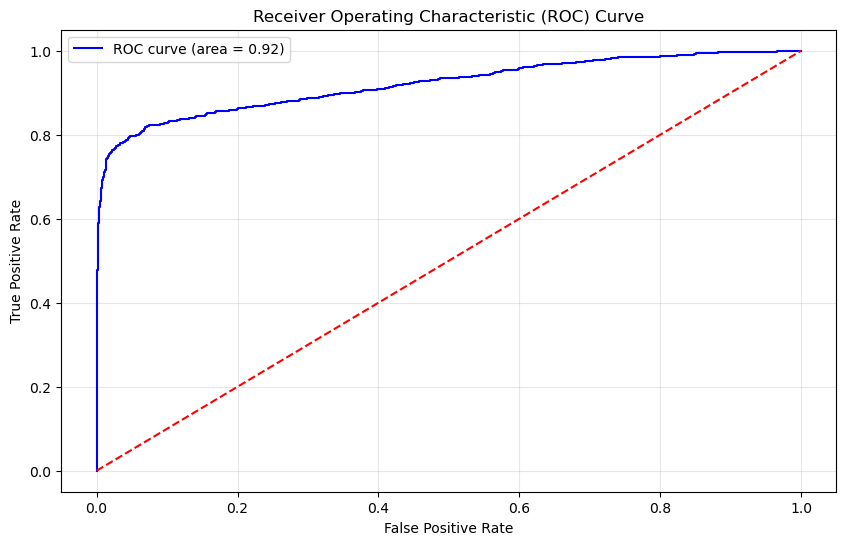

In [24]:
#write code to display roc curve of the model
batch_size=64
train_loader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(model, data_loader):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(alpha=0.3)
    return plt.show()

plot_roc_curve(alexnet_best_model,  test_loader)

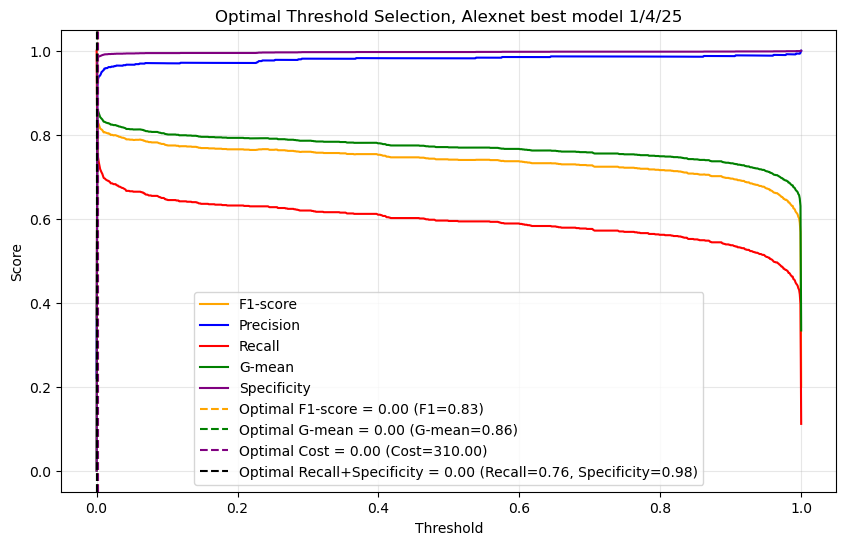

(0.002002002002002002,
 0.001001001001001001,
 0.002002002002002002,
 0.001001001001001001)

In [25]:
test_loader= DataLoader(test_dataset, batch_size=128, shuffle=False)
evaluate_model_thresholds(model=alexnet_best_model,data_loader=test_loader,)

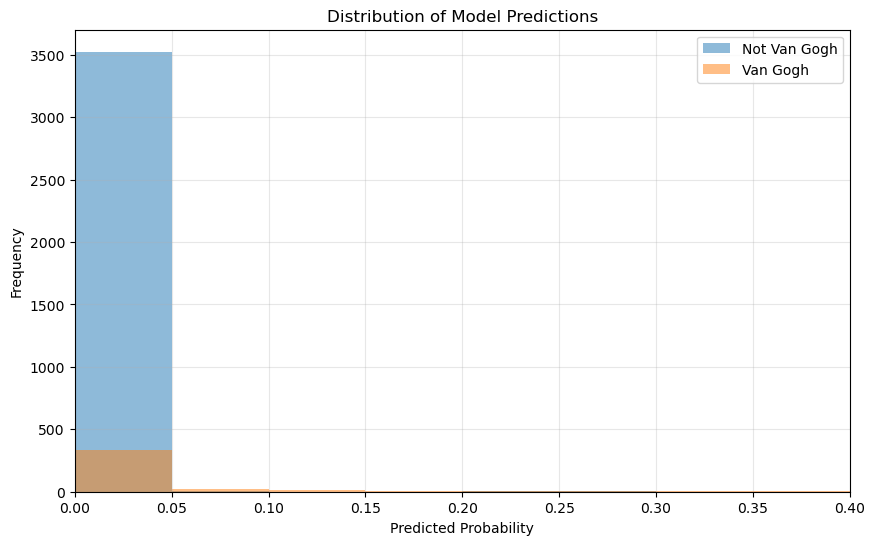

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_model_distribution(model, data_loader, class_names=["Class 0", "Class 1"]):
    """
    Plots the distribution of the model's results, with observations from each class in a different color.

    Parameters:
    - model: The trained model to evaluate.
    - data_loader: DataLoader providing the input data and labels.
    - class_names: List of class names for labeling the plot.
    """
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    plt.figure(figsize=(10, 6))
    for class_idx, class_name in enumerate(class_names):
        class_probs = all_probs[all_labels == class_idx]
        plt.hist(class_probs, bins=20, alpha=0.5, label=class_name)

    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Model Predictions')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xlim(0, 0.4)  # Zoom in on the left section between 0 and 0.4 on the X axis
    plt.show()

# Example usage
plot_model_distribution(alexnet_best_model, test_loader, class_names=["Not Van Gogh", "Van Gogh"])

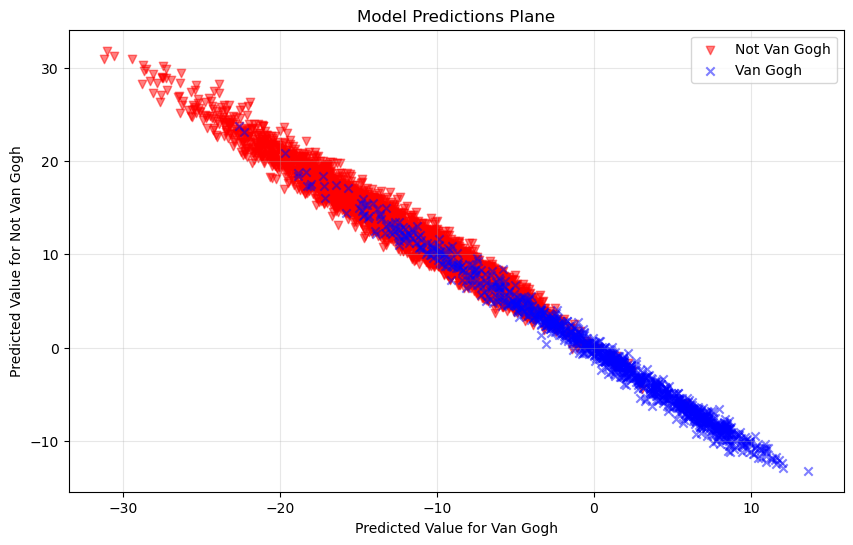

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_model_predictions_plane(model, data_loader, class_names=["Not Van Gogh", "Van Gogh"]):
    """
    Plots the observations as data points on a plane where the x values are the raw predictions for Van Gogh
    and the y values are the raw predictions for Not Van Gogh.

    Parameters:
    - model: The trained model to evaluate.
    - data_loader: DataLoader providing the input data and labels.
    - class_names: List of class names for labeling the plot.
    """
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            probs = outputs
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    plt.figure(figsize=(10, 6))
    colors = ['#FF0000', '#0000FF']  # Red and Blue colors
    markers = ['v', 'x']  # Dot for Not Van Gogh, Circle for Van Gogh
    for class_idx, class_name in enumerate(class_names):
        class_probs = all_probs[all_labels == class_idx]
        plt.scatter(class_probs[:, 1], class_probs[:, 0], alpha=0.5, label=class_name, color=colors[class_idx], marker=markers[class_idx])

    plt.xlabel('Predicted Value for Van Gogh')
    plt.ylabel('Predicted Value for Not Van Gogh')
    plt.title('Model Predictions Plane')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Example usage
plot_model_predictions_plane(alexnet_best_model, test_loader, class_names=["Not Van Gogh", "Van Gogh"])

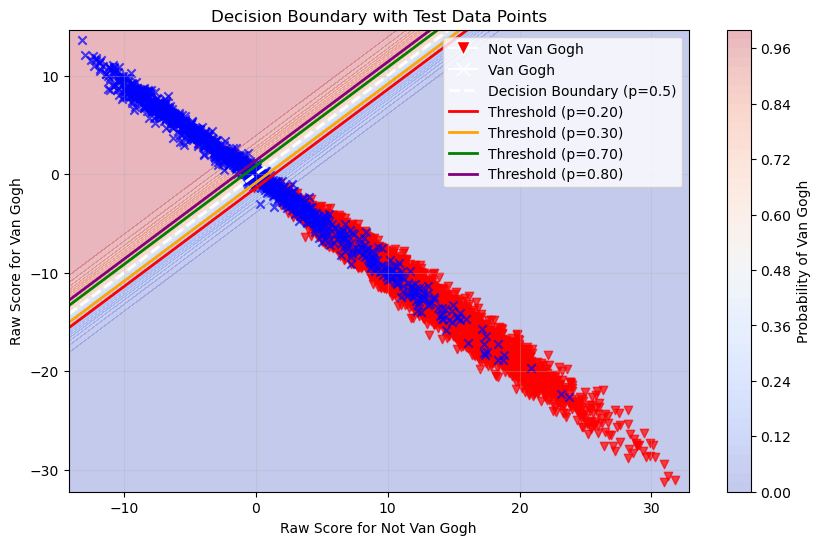

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_decision_boundary_with_contour(model, data_loader, class_names=["Not Van Gogh", "Van Gogh"],
                                        thresholds=None, threshold_colors=None):
    """
    Plots the observations as data points on a plane where the axes are the raw logits,
    with a contour map showing the softmax probabilities.

    Parameters:
    - model: The trained model to evaluate
    - data_loader: DataLoader providing the input data and labels
    - class_names: List of class names for labeling the plot
    - thresholds: List of threshold values to highlight on the contour plot
    - threshold_colors: List of colors for each threshold (defaults to rainbow colors)
    """
    model.eval()
    all_labels = []
    all_outputs = []
    all_probs = []

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)
    all_probs = np.array(all_probs)

    # Create a grid for the contour plot
    x_min, x_max = all_outputs[:, 0].min() - 1, all_outputs[:, 0].max() + 1
    y_min, y_max = all_outputs[:, 1].min() - 1, all_outputs[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Calculate softmax probabilities for the grid points
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    grid_probs = np.exp(grid_points[:, 1]) / (np.exp(grid_points[:, 0]) + np.exp(grid_points[:, 1]))
    zz = grid_probs.reshape(xx.shape)

    plt.figure(figsize=(10, 6))

    # Plot the contour
    contour = plt.contourf(xx, yy, zz, levels=50, cmap='coolwarm', alpha=0.3)
    plt.colorbar(contour, label='Probability of Van Gogh')

    # Plot the default decision boundary (p=0.5)
    decision_boundary = plt.contour(xx, yy, zz, levels=[0.5], colors='white', linestyles='--', linewidths=2)

    # Create custom legend entries
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='white', linestyle='--', lw=2)]
    custom_labels = ['Decision Boundary (p=0.5)']

    # Add custom thresholds if provided
    if thresholds is not None:
        if threshold_colors is None:
            # Generate rainbow colors if not provided
            import matplotlib.cm as cm
            threshold_colors = cm.rainbow(np.linspace(0, 1, len(thresholds)))

        for i, threshold in enumerate(thresholds):
            color = threshold_colors[i]
            threshold_line = plt.contour(xx, yy, zz, levels=[threshold],
                                        colors=[color], linestyles='-', linewidths=2)
            custom_lines.append(Line2D([0], [0], color=color, linestyle='-', lw=2))
            custom_labels.append(f'Threshold (p={threshold:.2f})')

    # Plot the data points
    colors = ['#FF0000', '#0000FF']  # Red and Blue colors
    markers = ['v', 'x']  # Different markers for each class
    for class_idx, class_name in enumerate(class_names):
        class_outputs = all_outputs[all_labels == class_idx]
        plt.scatter(class_outputs[:, 0], class_outputs[:, 1],
                    alpha=0.7, label=class_name,
                    color=colors[class_idx], marker=markers[class_idx])

    # Create combined legend with class points and decision boundary
    plt.legend(handles=[
        *[plt.Line2D([0], [0], marker=markers[i], color='w', markerfacecolor=colors[i],
                    markersize=10, label=class_names[i]) for i in range(len(class_names))],
        *custom_lines
    ], labels=[*class_names, *custom_labels])

    plt.xlabel('Raw Score for Not Van Gogh')
    plt.ylabel('Raw Score for Van Gogh')
    plt.title('Decision Boundary with Test Data Points')
    plt.grid(alpha=0.3)
    plt.show()

# Example usage
thresholds = [0.2, 0.3, 0.7, 0.8]
threshold_colors = ['red', 'orange', 'green', 'purple']
plot_decision_boundary_with_contour(alexnet_best_model, test_loader,
                                   class_names=["Not Van Gogh", "Van Gogh"],
                                   thresholds=thresholds,
                                   threshold_colors=threshold_colors)

# Style transfer function